#Введение

##Импорты

Импорт для перезагрузки импортов:


In [1]:
import importlib
import autoreload
%load_ext autoreload
%autoreload 2

Импорт (из) ключевых библиотек:

In [2]:
import numpy as np
import scipy as sc
import pandas as pd
from scipy.special import expit as sgm

Импорт отображения графиков:

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl

Импорт библиотеки регулярных выражений:

In [4]:
import re

Импорт для чтения датасета:

In [5]:
import csv

Импорт для преобразования датасета:

In [6]:
from sklearn.feature_extraction.text import CountVectorizer

Импорт для лемматизации и удаления стоп-слов:


In [133]:
from sklearn.feature_extraction.text import TfidfTransformer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

Импорт для n-грамм:

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

Импорт классификаторов:

In [7]:
# !pip install progress

In [8]:
from binclasslib.optimization import GDClassifier, SGDClassifier

## Считываем датасет

Формируем датафреймы из исходной, необработанной информации:

In [9]:
data_dir = 'data'
delim = '/'
data_train = pd.read_csv(data_dir + delim + 'toxic_train.csv')
data_test = pd.read_csv(data_dir + delim + 'toxic_test.csv')

Посмотрим на train:

In [10]:
data_train

,Unnamed: 0,comment_text,is_toxic
0,0,Explanation\nWhy the edits made under my usern...,False
1,1,D'aww! He matches this background colour I'm s...,False
2,2,"Hey man, I'm really not trying to edit war. It...",False
3,3,"""\nMore\nI can't make any real suggestions on ...",False
4,4,"You, sir, are my hero. Any chance you remember...",False
...,...,...,...
52056,159494,"""\n\n our previous conversation \n\nyou fuckin...",True
52057,159514,YOU ARE A MISCHIEVIOUS PUBIC HAIR,True
52058,159541,Your absurd edits \n\nYour absurd edits on gre...,True
52059,159546,"""\n\nHey listen don't you ever!!!! Delete my e...",True


Посмотрим на test:

In [11]:
data_test

,Unnamed: 0,comment_text,is_toxic
0,0,Thank you for understanding. I think very high...,False
1,1,:Dear god this site is horrible.,False
2,2,"""::: Somebody will invariably try to add Relig...",False
3,3,""" \n\n It says it right there that it IS a typ...",False
4,4,""" \n\n == Before adding a new product to the l...",False
...,...,...,...
20671,63877,NIGEL IS A CRAZY IDIOT!!!,True
20672,63935,""" \n ::Well, now don't I feel stupid.... · """,True
20673,63945,==Fourth Baldrick possibly being cleverer than...,True
20674,63962,""" \n\n == IRAN == \n That’s right, Iran. It wa...",True


#Эксперимент №1: Предварительная обработка текста

Функция, которая приводит все тексты из массива к нижнему регистру и заменяет в тексте все символы, не являющиеся буквами и цифрами, на пробелы:


In [12]:
def preprocess_corpus(arr):
  res = []
  for s in arr:
    res += [re.sub('[^a-z0-9]+', ' ', s.lower()).strip()]
  return res

Функция, преобразующая метку токсичности комментария в метки классов: 1 (toxic) и -1 (non-toxic)

In [13]:
def transform_ans(arr):
  res = []
  for v in arr:
    res += [1 if v == True else -1]
  return np.array(res)

Предобработка текста и откликов под нашу задачу и выделение обучающей и тестовой выборок (объекты - комментарии - образуют корпусы текстов):

In [14]:
X_train_corpus, y_train = (preprocess_corpus(data_train['comment_text'].values),
                         transform_ans(data_train['is_toxic'].values))
X_test_corpus, y_test = (preprocess_corpus(data_test['comment_text'].values),
                       transform_ans(data_test['is_toxic'].values))

#Эксперимент №2: Преобразование выборок

Преобразуем выборки в разреженные матрицы встречаемости слова в комментарии (строки $-$ комментарии, столбцы $-$ слова) с помощью CountVectorizer (оставим только слова, которые встречаются в `mindf=5` и более документах):

In [15]:
vectorizer = CountVectorizer(min_df=5)
X_train = vectorizer.fit_transform(X_train_corpus)
X_test = vectorizer.transform(X_test_corpus)
X_train.shape, X_test.shape

((52061, 18253), (20676, 18253))

Выделим из обучающей выборки **валидационную**, для лучшего подбора гиперпараметров:

In [16]:
def train_valid_split(X, y, train_size=None, shuffle=False, seed=0):
  n = len(y)
  if train_size == None:
    train_size = int(0.75 * n)
  if shuffle:
    ind = np.random.default_rng(seed).permutation(n)
    X, y = X[ind], y[ind]
    return (X[:train_size], y[:train_size]), (X[train_size:], y[train_size:])

In [17]:
(X_train_, y_train_), (X_valid_, y_valid_) = train_valid_split(X_train,
                                                               y_train,
                                                               train_size=40000,
                                                               shuffle=True)

In [18]:
valid_dataset = (X_valid_, y_valid_)

###Дополнительно

Настройки для графиков:

In [19]:
plt.rc('axes', axisbelow=True, grid=True)
plt.rc('grid', c='grey', ls=':')
plt.rc('savefig', bbox='tight', pad_inches=0.1, format='pdf')

# From https://matplotlib.org/stable/gallery/color/named_colors.html
graph_colors = [
    'powderblue',
    '#ff7f0e','#1f77b4',
    '#2ca02c', '#d62728',
    '#9467bd', '#8c564b',
    '#e377c2', '#7f7f7f',
    '#bcbd22', '#17becf']

plt.rc('axes', prop_cycle=plt.cycler(color=graph_colors))
plt.rc('legend', labelspacing=0.1)

In [ ]:
# def fastinfo():
#     plt.figure(figsize=(10,4))
#     plt.subplot(1,2,1)
#     if 'epoch_num' in history:
#         iters = history['epoch_num']
#     else:
#         iters = np.arange(len(history['func']))
#     plt.plot(iters, history['func'])
#     plt.subplot(1,2,2)
#     plt.plot(iters, history['acc'])
#     print(f'time: {np.sum(history["time"]):3f} s')
#     print(f'acc: {(model.predict(X_test) == y_test).mean():.3f}')

#Эксперименты №3 и №4: GD и SGD

##Исследование зависимости от $\alpha$ и $\beta$

Рассмотрим зависимости **loss** и **accuracy** от **итерации (эпохи)** и от **реального времени** для обоих методов: **GD** и **SGD** $-$ при разных наборах гиперпараметров: `step_alpha` ($\alpha$), `step_beta` ($\beta$), `w_0` ($w_0$), `batch_size`.

In [20]:
alpha_arr = np.logspace(1, -3, 5)
beta_arr = [0, 0.1, 0.5, 1, 2]

###GD:

In [287]:
history_dict = {}
for beta in beta_arr:
    for alpha in alpha_arr:
        model = GDClassifier(step_alpha=alpha, step_beta=beta)
        history_dict[(beta, alpha)] = model.fit(X_train_, y_train_,
                                             dataset=valid_dataset)
np.save('bin/alpha-beta_gd.npy', history_dict)

  1%|▏         | 14/1001 [00:00<00:31, 31.49it/s]


In [38]:
history_dict = np.load('bin/alpha-beta_gd.npy', allow_pickle=True).item()

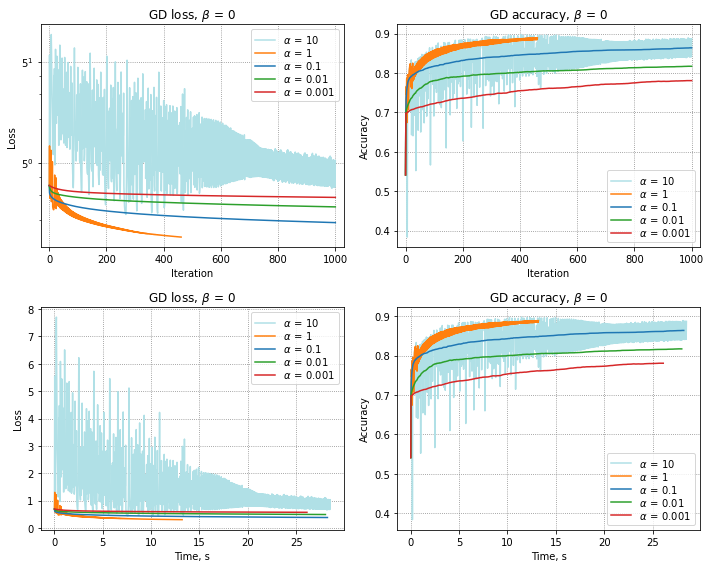

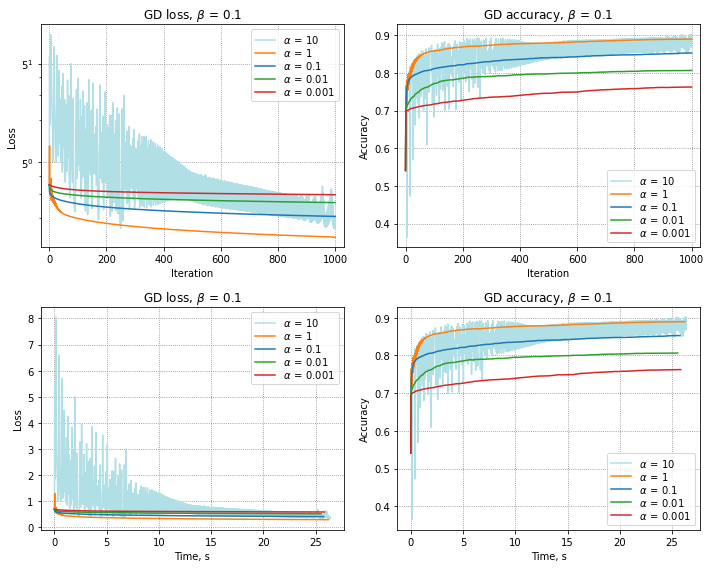

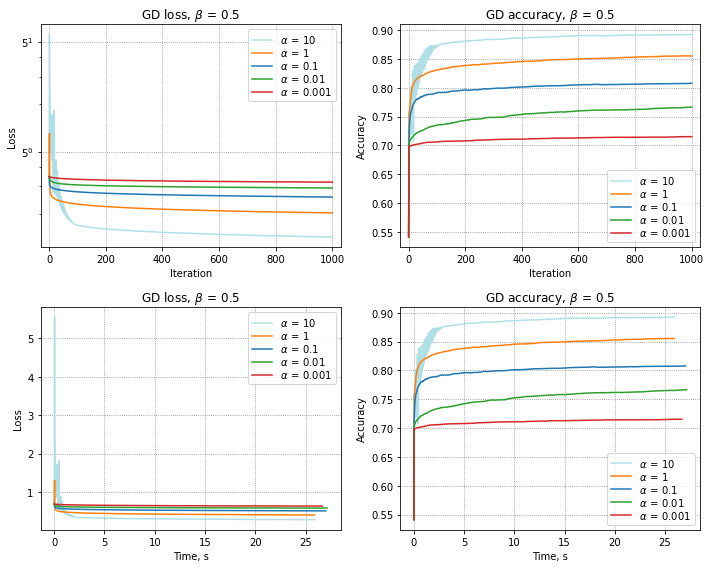

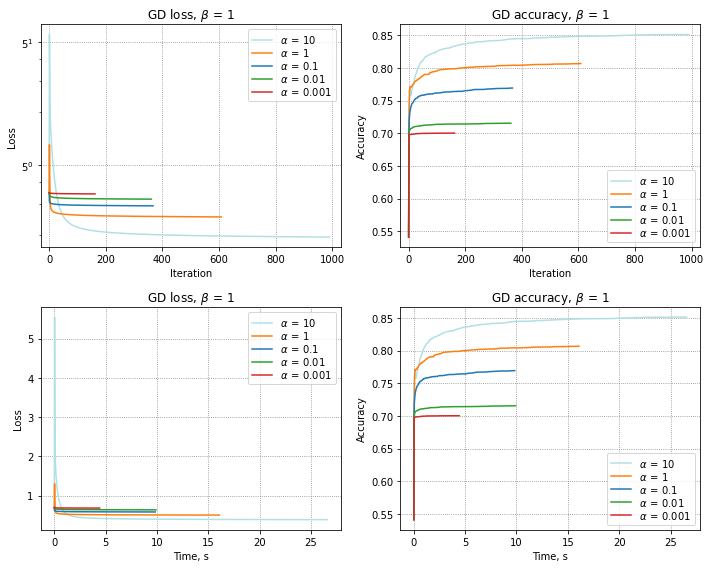

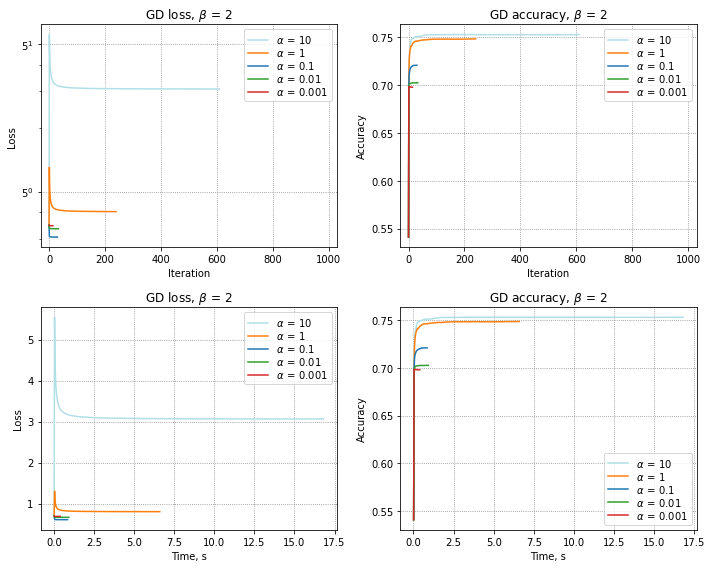

In [293]:
for i, beta in enumerate(beta_arr):
    plt.figure(figsize=(10, 8))

    plt.subplot(2,2,1)
    plt.title(f'GD loss, $\\beta\,=\,${beta:g}')
    for alpha in alpha_arr:
        y = history_dict[beta, alpha]['func']
        x = np.arange(len(y))
        plt.plot(x, y, label=f'$\\alpha\,=\,${alpha:g}')
        plt.xlabel('Iteration')
        plt.ylabel('Loss')
        plt.yscale('log', basey=5)
        plt.xlim(-30, 1030)
    plt.legend()

    plt.subplot(2,2,2)
    plt.title(f'GD accuracy, $\\beta\,=\,${beta:g}')
    for alpha in alpha_arr:
        y = history_dict[beta, alpha]['acc']
        x = np.arange(len(y))
        plt.plot(x, y, label=f'$\\alpha\,=\,${alpha:g}')
        plt.xlabel('Iteration')
        plt.ylabel('Accuracy')
        plt.xlim(-30, 1030)
    plt.legend()

    plt.subplot(2,2,3)
    plt.title(f'GD loss, $\\beta\,=\,${beta:g}')
    for alpha in alpha_arr:
        point = history_dict[beta, alpha]
        y = point['func']
        x = np.cumsum(point['time'])
        plt.plot(x, y, label=f'$\\alpha\,=\,${alpha:g}')
        plt.xlabel('Time, s')
        plt.ylabel('Loss')
    plt.legend()

    plt.subplot(2,2, 4)
    plt.title(f'GD accuracy, $\\beta\,=\,${beta:g}')
    for alpha in alpha_arr:
        point = history_dict[beta, alpha]
        y = point['acc']
        x = np.cumsum(point['time'])

        plt.plot(x, y, label=f'$\\alpha\,=\,${alpha:g}')
        plt.xlabel('Time, s')
        plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.savefig(f'vis/alpha-beta_gd_{i}')
    plt.show()

Лучшие $\alpha$ и $\beta$ (по accuracy):

In [75]:
def best_acc_from_dict(hist_dict, top=5):
    dict = {par: max(history_dict[par]['acc']) for par in hist_dict}
    return sorted(dict.items(), key=lambda item: item[1])[::-1][:top]

In [76]:
best_acc_from_dict(history_dict)

[((0.1, 10.0), 0.9015836166155377),
 ((0, 10.0), 0.8977696708398972),
 ((0.5, 10.0), 0.8923803996351878),
 ((0.1, 1.0), 0.889727219965177),
 ((0, 1.0), 0.8889810131829865)]

###SGD:

In [277]:
history_dict = {}
for beta in beta_arr:
    for alpha in alpha_arr:
        model = SGDClassifier(step_alpha=alpha, step_beta=beta)
        history_dict[(beta, alpha)] = model.fit(X_train_, y_train_,
                                                dataset=valid_dataset)
np.save('bin/alpha-beta_sgd.npy', history_dict)

  4%|▎         | 37/1000 [00:03<01:27, 11.06it/s]


In [77]:
history_dict = np.load('bin/alpha-beta_sgd.npy', allow_pickle=True).item()

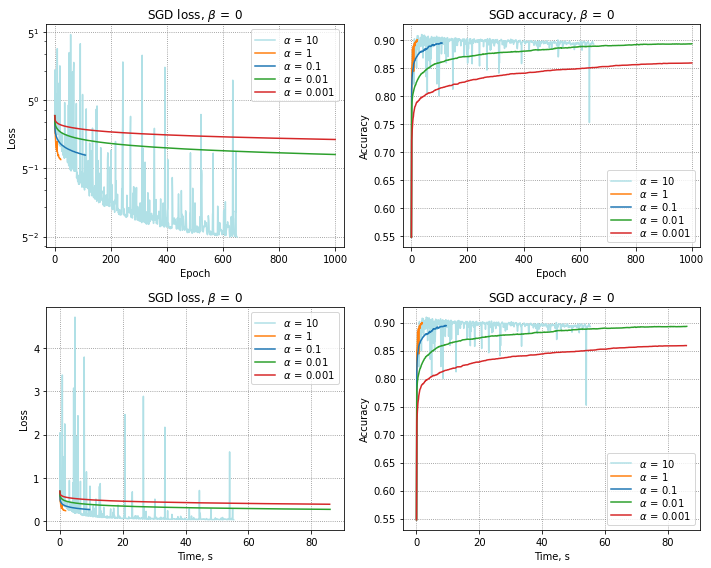

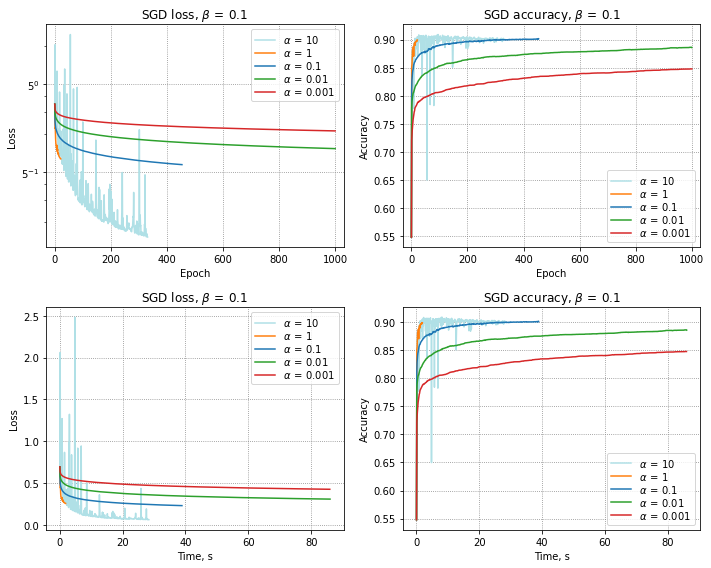

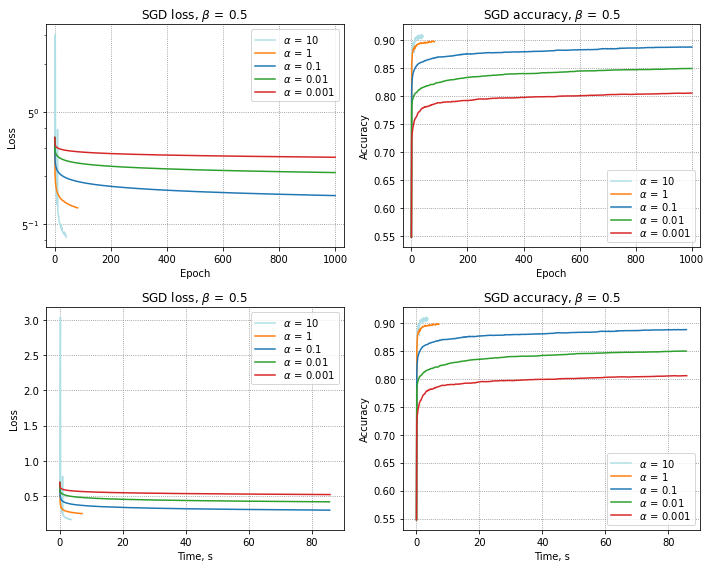

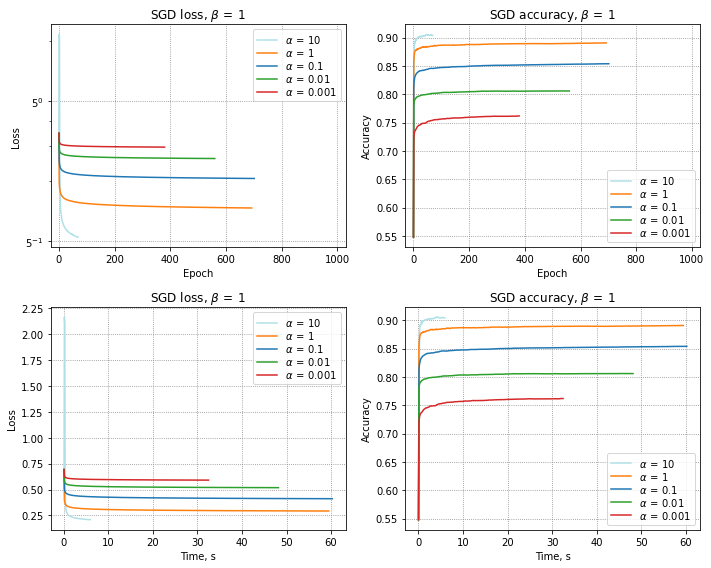

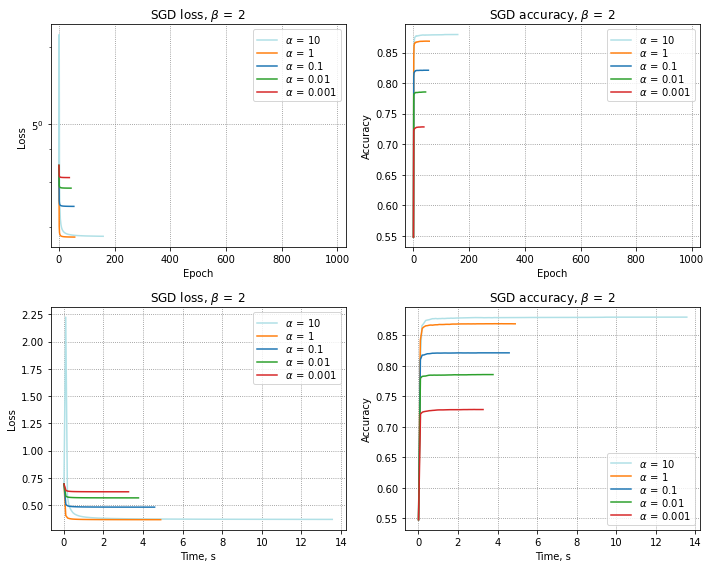

In [290]:
for i, beta in enumerate(beta_arr):
    plt.figure(figsize=(10, 8))

    plt.subplot(2,2,1)
    plt.title(f'SGD loss, $\\beta\,=\,${beta:g}')
    for alpha in alpha_arr:
        point = history_dict[beta, alpha]
        y = point['func']
        x = point['epoch_num']
        plt.plot(x, y, label=f'$\\alpha\,=\,${alpha:g}')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.yscale('log', basey=5)
        plt.xlim(-30, 1030)
    plt.legend()

    plt.subplot(2,2,2)
    plt.title(f'SGD accuracy, $\\beta\,=\,${beta:g}')
    for alpha in alpha_arr:
        point = history_dict[beta, alpha]
        y = point['acc']
        x = point['epoch_num']
        plt.plot(x, y, label=f'$\\alpha\,=\,${alpha:g}')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.xlim(-30, 1030)
    plt.legend()

    plt.subplot(2,2,3)
    plt.title(f'SGD loss, $\\beta\,=\,${beta:g}')
    for alpha in alpha_arr:
        point = history_dict[beta, alpha]
        y = point['func']
        x = np.cumsum(point['time'])
        plt.plot(x, y, label=f'$\\alpha\,=\,${alpha:g}')
        plt.xlabel('Time, s')
        plt.ylabel('Loss')
    plt.legend()

    plt.subplot(2,2, 4)
    plt.title(f'SGD accuracy, $\\beta\,=\,${beta:g}')
    for alpha in alpha_arr:
        point = history_dict[beta, alpha]
        y = point['acc']
        x = np.cumsum(point['time'])
        plt.plot(x, y, label=f'$\\alpha\,=\,${alpha:g}')
        plt.xlabel('Time, s')
        plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.savefig(f'vis/alpha-beta_sgd_{i}')
    plt.show()

In [82]:
best_acc_from_dict(history_dict)

[((0.5, 10.0), 0.9104551861371363),
 ((0, 10.0), 0.9098748030843213),
 ((0.1, 10.0), 0.9092115081668187),
 ((1, 10.0), 0.9055633861205539),
 ((0.1, 0.1), 0.9015836166155377)]

##Исследование зависимости от $w_0$

In [21]:
n = X_train_.shape[1]
bound_1 = 1 / (2 * n)
bound_2 = 1 / np.sqrt(n)

In [26]:
#http://machinelearning.ru/wiki/images/5/53/Voron-ML-Lin-SG.pdf
w_0_arr = [
    np.zeros(n),
    np.ones(n),
    np.random.default_rng(seed=0).uniform(-bound_1, bound_1, size=n),
    np.random.default_rng(seed=0).uniform(-bound_2, bound_2, size=n),
    X_train_.T.dot(y_train_) / (np.array(X_train_.power(2).sum(axis=0))[0] + 1),
]

w_0_labels = [
    '(0, 0, ..., 0)',
    '(1, 1, ..., 1)',
    '~' + r'$U[-\frac{1}{2d},\frac{1}{2d}]$',
    '~' + r'$U[-\frac{1}{\sqrt{d}},\frac{1}{\sqrt{d}}]$',
    r"$\frac{\left<{y}, {x}_i'\right>}{\left<{x}_i',{x}_i'\right>}$",
]

w_0_names = [str(j + 1)+'.' for j in range(len(w_0_arr))]

std_alpha = 1
std_beta = 0

###GD:

In [296]:
history_dict = {}

for w_0, name in zip(w_0_arr, w_0_names):
    # параметры классификатора по умолчанию
    history_dict[name] = GDClassifier().fit(X_train_, y_train_, w_0=w_0, dataset=valid_dataset)
np.save('bin/w_0_gd.npy', history_dict)

100%|██████████| 1001/1001 [00:29<00:00, 33.63it/s]


In [297]:
history_dict = np.load('bin/w_0_gd.npy', allow_pickle=True).item()

In [298]:
def alpha_by_name_1(name):
    if name != '2.':
        return 0.2
    return 1

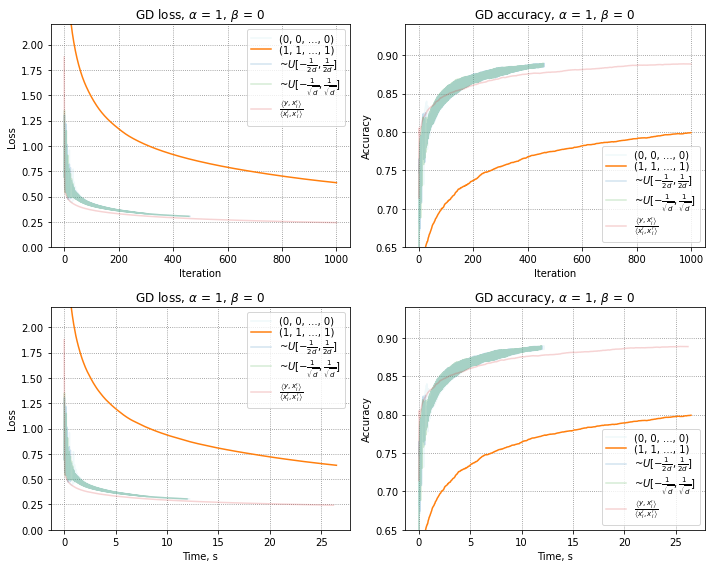

In [299]:
plt.figure(figsize=(10, 8))

plt.subplot(2,2,1)
plt.title(f'GD loss, $\\alpha\,=\,{std_alpha},\,\\beta\,=\,{std_beta}$')
for name, label in zip(w_0_names, w_0_labels):
    point = history_dict[name]
    y = point['func']
    x = np.arange(len(y))
    plt.plot(x, y, label=label, alpha=alpha_by_name_1(name))
    plt.xlabel('Iteration')
    plt.ylabel('Loss')
    plt.ylim(0, 2.2)
plt.legend()

plt.subplot(2,2,2)
plt.title(f'GD accuracy, $\\alpha\,=\,{std_alpha},\,\\beta\,=\,{std_beta}$')
for name, label in zip(w_0_names, w_0_labels):
    point = history_dict[name]
    y = point['acc']
    x = np.arange(len(y))
    plt.plot(x, y, label=label, alpha=alpha_by_name_1(name))
    plt.xlabel('Iteration')
    plt.ylabel('Accuracy')
    plt.ylim(0.65, 0.94)
plt.legend()

plt.subplot(2,2,3)
plt.title(f'GD loss, $\\alpha\,=\,{std_alpha},\,\\beta\,=\,{std_beta}$')
for name, label in zip(w_0_names, w_0_labels):
    point = history_dict[name]
    y = point['func']
    x = np.cumsum(point['time'])
    plt.plot(x, y, label=label, alpha=alpha_by_name_1(name))
    plt.xlabel('Time, s')
    plt.ylabel('Loss')
    plt.ylim(0, 2.2)
plt.legend()

plt.subplot(2,2,4)
plt.title(f'GD accuracy, $\\alpha\,=\,{std_alpha},\,\\beta\,=\,{std_beta}$')
for name, label in zip(w_0_names, w_0_labels):
    point = history_dict[name]
    y = point['acc']
    x = np.cumsum(point['time'])
    plt.plot(x, y, label=label, alpha=alpha_by_name_1(name))
    plt.xlabel('Time, s')
    plt.ylabel('Accuracy')
    plt.ylim(0.65, 0.94)
plt.legend()

plt.tight_layout()
plt.savefig(f'vis/w_0_gd')
plt.show()

###SGD:

In [300]:
history_dict = {}

for w_0, name in zip(w_0_arr, w_0_names):
    # параметры классификатора по умолчанию
    history_dict[name] = SGDClassifier().fit(X_train_, y_train_, w_0=w_0, dataset=valid_dataset)
np.save('bin/w_0_sgd.npy', history_dict)

 30%|███       | 300/1000 [00:26<01:02, 11.17it/s]


In [301]:
history_dict = np.load('bin/w_0_sgd.npy', allow_pickle=True).item()

In [302]:
def alpha_by_name_2(name):
    if name != '2.' and name != '1.':
        return 0.6
    return 1

def lw_by_name(name):
    if name == '1.':
        return 5
    return 1.5

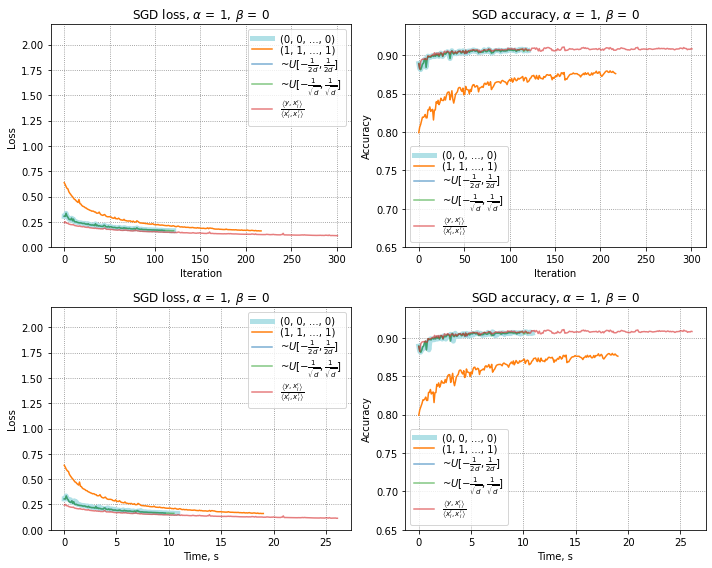

In [303]:
plt.figure(figsize=(10, 8))

plt.subplot(2,2,1)
plt.title(f'SGD loss, $\\alpha\,=\,{std_alpha},\,\\beta\,=\,{std_beta}$')
for name, label in zip(w_0_names, w_0_labels):
    point = history_dict[name]
    y = point['func']
    x = point['epoch_num']
    plt.plot(x, y, label=label, alpha=alpha_by_name_2(name),
                                lw=lw_by_name(name))
    plt.xlabel('Iteration')
    plt.ylabel('Loss')
    plt.ylim(0, 2.2)
plt.legend()

plt.subplot(2,2,2)
plt.title(f'SGD accuracy, $\\alpha\,=\,{std_alpha},\,\\beta\,=\,{std_beta}$')
for name, label in zip(w_0_names, w_0_labels):
    point = history_dict[name]
    y = point['acc']
    x = point['epoch_num']
    plt.plot(x, y, label=label, alpha=alpha_by_name_2(name),
                                lw=lw_by_name(name))
    plt.xlabel('Iteration')
    plt.ylabel('Accuracy')
    plt.ylim(0.65, 0.94)
plt.legend()

plt.subplot(2,2,3)
plt.title(f'SGD loss, $\\alpha\,=\,{std_alpha},\,\\beta\,=\,{std_beta}$')
for name, label in zip(w_0_names, w_0_labels):
    point = history_dict[name]
    y = point['func']
    x = np.cumsum(point['time'])
    plt.plot(x, y, label=label, alpha=alpha_by_name_2(name),
                                lw=lw_by_name(name))
    plt.xlabel('Time, s')
    plt.ylabel('Loss')
    plt.ylim(0, 2.2)
plt.legend()

plt.subplot(2,2,4)
plt.title(f'SGD accuracy, $\\alpha\,=\,{std_alpha},\,\\beta\,=\,{std_beta}$')
for name, label in zip(w_0_names, w_0_labels):
    point = history_dict[name]
    y = point['acc']
    x = np.cumsum(point['time'])
    plt.plot(x, y, label=label, alpha=alpha_by_name_2(name),
                                lw=lw_by_name(name))
    plt.xlabel('Time, s')
    plt.ylabel('Accuracy')
    plt.ylim(0.65, 0.94)
plt.legend()

plt.tight_layout()
plt.savefig(f'vis/w_0_sgd')
plt.show()

##Исследование зависимости от `batch_size` (SGD)

In [29]:
batch_sizes = np.logspace(4, 0, 5).astype(int)
bs_arr = batch_sizes[::-1]

In [306]:
history_dict = {}
for bs in batch_sizes:
    model = SGDClassifier(batch_size=bs)
    history_dict[bs] = model.fit(X_train_, y_train_,
                                         dataset=valid_dataset)
np.save('bin/bs_beta0_sgd.npy', history_dict)

100%|██████████| 1000/1000 [4:00:06<00:00, 14.41s/it]


In [23]:
history_dict = np.load('bin/bs_beta0_sgd.npy', allow_pickle=True).item()

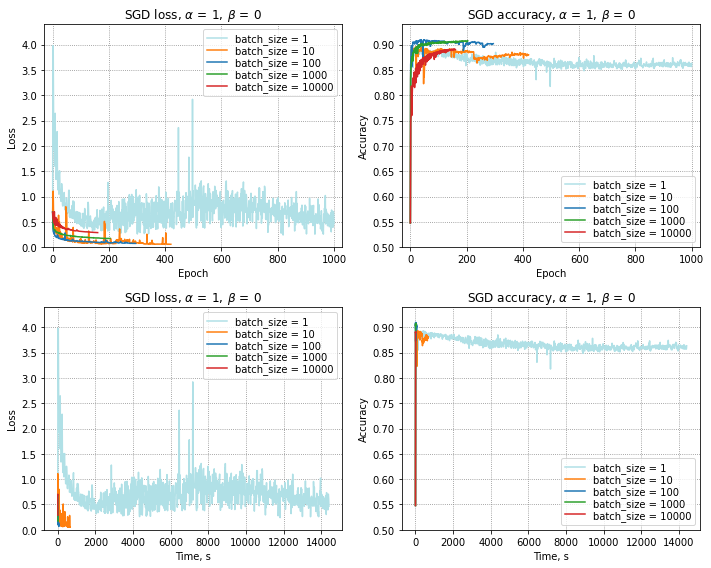

In [28]:
plt.figure(figsize=(10, 8))

plt.subplot(2,2,1)
plt.title(f'SGD loss, $\\alpha\,=\,{std_alpha},\,\\beta\,=\,{std_beta}$')
for bs in bs_arr:
    point = history_dict[bs]
    y = point['func']
    x = point['epoch_num']
    plt.plot(x, y, label=f'batch_size = {bs:g}')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.ylim(0, 4.4)
    plt.xlim(-30, 1030)
plt.legend()

plt.subplot(2,2,2)
plt.title(f'SGD accuracy, $\\alpha\,=\,{std_alpha},\,\\beta\,=\,{std_beta}$')
for bs in bs_arr:
    point = history_dict[bs]
    y = point['acc']
    x = point['epoch_num']
    plt.plot(x, y, label=f'batch_size = {bs:g}')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.ylim(0.5, 0.94)
    plt.xlim(-30, 1030)
plt.legend()

plt.subplot(2,2,3)
plt.title(f'SGD loss, $\\alpha\,=\,{std_alpha},\,\\beta\,=\,{std_beta}$')
for bs in bs_arr:
    point = history_dict[bs]
    y = point['func']
    x = np.cumsum(point['time'])
    plt.plot(x, y, label=f'batch_size = {bs:g}')
    plt.xlabel('Time, s')
    plt.ylabel('Loss')
    plt.ylim(0, 4.4)
plt.legend()

plt.subplot(2,2,4)
plt.title(f'SGD accuracy, $\\alpha\,=\,{std_alpha},\,\\beta\,=\,{std_beta}$')
for bs in bs_arr:
    point = history_dict[bs]
    y = point['acc']
    x = np.cumsum(point['time'])
    plt.plot(x, y, label=f'batch_size = {bs:g}')
    plt.xlabel('Time, s')
    plt.ylabel('Accuracy')
    plt.ylim(0.5, 0.94)
plt.legend()

plt.tight_layout()
plt.savefig('vis/bs_beta0_sgd')
plt.show()

In [308]:
history_dict = {}
for bs in batch_sizes:
    model = SGDClassifier(step_beta=0.5, batch_size=bs)
    history_dict[bs] = model.fit(X_train_, y_train_,
                                         dataset=valid_dataset)
np.save('bin/bs_beta0-5_sgd.npy', history_dict)

 35%|███▌      | 353/1000 [1:27:08<2:39:42, 14.81s/it]


In [30]:
history_dict = np.load('bin/bs_beta0-5_sgd.npy', allow_pickle=True).item()

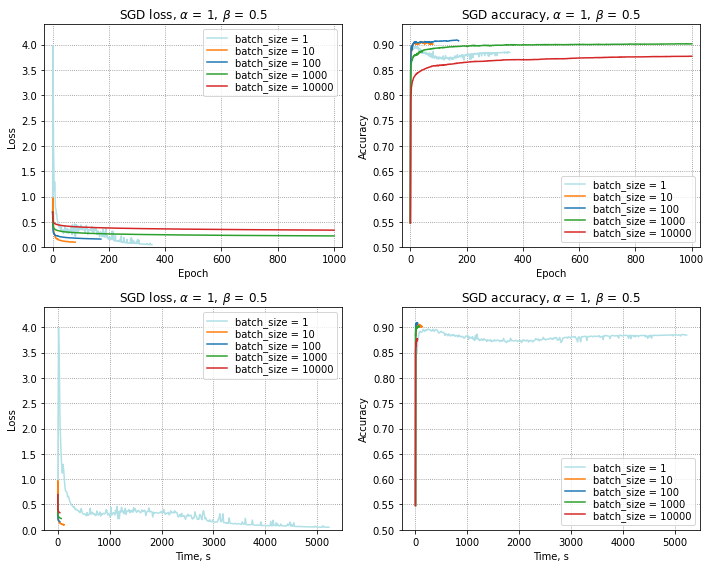

In [32]:
plt.figure(figsize=(10, 8))

plt.subplot(2,2,1)
plt.title(f'SGD loss, $\\alpha\,=\,{std_alpha},\,\\beta\,=\,{0.5}$')
for bs in bs_arr:
    point = history_dict[bs]
    y = point['func']
    x = point['epoch_num']
    plt.plot(x, y, label=f'batch_size = {bs:g}')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.ylim(0, 4.4)
    plt.xlim(-30, 1030)
plt.legend()

plt.subplot(2,2,2)
plt.title(f'SGD accuracy, $\\alpha\,=\,{std_alpha},\,\\beta\,=\,{0.5}$')
for bs in bs_arr:
    point = history_dict[bs]
    y = point['acc']
    x = point['epoch_num']
    plt.plot(x, y, label=f'batch_size = {bs:g}')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.ylim(0.5, 0.94)
    plt.xlim(-30, 1030)
plt.legend()

plt.subplot(2,2,3)
plt.title(f'SGD loss, $\\alpha\,=\,{std_alpha},\,\\beta\,=\,{0.5}$')
for bs in bs_arr:
    point = history_dict[bs]
    y = point['func']
    x = np.cumsum(point['time'])
    plt.plot(x, y, label=f'batch_size = {bs:g}')
    plt.xlabel('Time, s')
    plt.ylabel('Loss')
    plt.ylim(0, 4.4)
plt.legend()

plt.subplot(2,2,4)
plt.title(f'SGD accuracy, $\\alpha\,=\,{std_alpha},\,\\beta\,=\,{0.5}$')
for bs in bs_arr:
    point = history_dict[bs]
    y = point['acc']
    x = np.cumsum(point['time'])
    plt.plot(x, y, label=f'batch_size = {bs:g}')
    plt.xlabel('Time, s')
    plt.ylabel('Accuracy')
    plt.ylim(0.5, 0.94)
plt.legend()

plt.tight_layout()
plt.savefig('vis/bs_beta0-5_sgd')
plt.show()

##Эксперимент №5: промежуточные итоги, baseline

Лучше брать SGD, он показывает большее качество, посмотрим медиану accuracy:

In [136]:
history_dict = np.load('bin/alpha-beta_sgd.npy', allow_pickle=True).item()

In [116]:
arr = best_acc_from_dict(history_dict, -1)
arr[len(arr) // 2]

((0.1, 0.01), 0.8864936572423514)

лучшие 5 наборов `step_alpha` и `step_beta` по $accuracy$ на валидационной выборке:

In [138]:
arr = best_acc_from_dict(history_dict, 5)
arr

[((0.5, 10.0), 0.9104551861371363),
 ((0, 10.0), 0.9098748030843213),
 ((0.1, 10.0), 0.9092115081668187),
 ((1, 10.0), 0.9055633861205539),
 ((0.1, 0.1), 0.9015836166155377)]

In [132]:
baseline = []
for (step_beta, step_alpha), acc in arr:
    history_dict = {}
    model = SGDClassifier(step_alpha=step_alpha, step_beta=step_beta)
    history_dict[bs] = model.fit(X_train, y_train)
    np.save(f'bin/baseline_alpha{step_alpha}_beta{step_beta}_sgd.npy', history_dict)
    baseline += [((step_beta, step_alpha), (model.predict(X_test) == y_test).mean())]
baseline

 27%|██▋       | 271/1000 [00:44<01:59,  6.08it/s]


[((0.5, 10.0), 0.866560263106984),
 ((0, 10.0), 0.8566453859547302),
 ((0.1, 10.0), 0.8608531630876378),
 ((1, 10.0), 0.864335461404527),
 ((0.1, 0.1), 0.8670922809053976)]

In [139]:
best_alpha, best_beta = 0.1, 0.1

Лучший алгоритм: $SGD, \alpha= 0.1, \beta=0.1, w_0 \sim U[$-$\frac{1}{2d}, \frac{1}{2d}]$

Далее по умолчанию будем использовать его

В среднем получаем $accuracy = 0.8671$

##Эксперимент №6: Лемматизация и удаление стоп-слов

Функция для лемматизации датасета:

In [144]:
def dataset_lemmatizer(X):
    X_lem = []
    for comment in X:
        X_lem += [' '.join(WordNetLemmatizer().lemmatize(word) for word in comment.split())]
    return X_lem

In [147]:
import nltk
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [148]:
from sklearn.feature_extraction.text import CountVectorizer

kwargs_arr = [
    {'min_df': 5},
    {'min_df': 5, 'stop_words': stopwords.words('english'),},
]

res = []
for kwargs in kwargs_arr:
    vectorizer = CountVectorizer(**kwargs)
    X_train, X_test = (vectorizer.fit_transform(X_train_corpus),
                       vectorizer.transform(X_test_corpus))
    print(f'Data dimension: {X_train.shape}')
    model = SGDClassifier(step_alpha=best_alpha, step_beta=best_beta)
    model.fit(X_train, y_train, trace=False)
    print(f'Accuracy: {(model.predict(X_test) == y_test).mean()}')
    
    vectorizer = CountVectorizer(**kwargs)
    X_train, X_test = (vectorizer.fit_transform(dataset_lemmatizer(X_train_corpus)),
                       vectorizer.transform(dataset_lemmatizer(X_test_corpus)))
    print(f'Data dimension: {X_train.shape}')
    model = SGDClassifier(step_alpha=1.5, step_beta=0.05)
    model.fit(X_train, y_train, trace=False)
    print(f'Accuracy: {(model.predict(X_test) == y_test).mean()}')

Data dimension: (52061, 18253)


 27%|██▋       | 271/1000 [00:33<01:29,  8.14it/s]


Accuracy: 0.8670922809053976
Data dimension: (52061, 16374)


 12%|█▏        | 116/1000 [00:14<01:47,  8.23it/s]


Accuracy: 0.871638614819114
Data dimension: (52061, 18109)


100%|██████████| 1000/1000 [01:47<00:00,  9.30it/s]


Accuracy: 0.8693654478622558
Data dimension: (52061, 16234)


  6%|▌         | 56/1000 [00:06<01:41,  9.28it/s]

Accuracy: 0.8684465080286322


##Эксперимент №7: влияние BagOfWords и Tfidf, min_df и max_df 

In [149]:
X_train_corpus = dataset_lemmatizer(X_train_corpus)
X_test_corpus = dataset_lemmatizer(X_test_corpus)

Tfidf:

In [156]:
for min_df in [1, 3, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50]:
    vectorizer = CountVectorizer(min_df=min_df)
    X_train, X_test = (vectorizer.fit_transform(X_train_corpus),
                       vectorizer.transform(X_test_corpus))
    model = SGDClassifier(step_alpha=best_alpha, step_beta=best_beta)
    model.fit(X_train, y_train, trace=False)
    print(f'BagOfWords, min_df={min_df},'
          f'features_quant={X_train.shape[1]},'
          f'accuracy={(model.predict(X_test) == y_test).mean()}')
    
    tfidfer = TfidfTransformer()
    tfidfer.fit(X_train)
    X_train, X_test = (tfidfer.transform(X_train),
                       tfidfer.transform(X_test))
    model = SGDClassifier(step_alpha=best_alpha, step_beta=best_beta)
    model.fit(X_train, y_train, trace=False)
    print(f'Tfidf, min_df={min_df},'
          f'features_quant={X_train.shape[1]},'
          f'accuracy={(model.predict(X_test) == y_test).mean()}')

 22%|██▏       | 223/1000 [00:35<02:03,  6.28it/s]


BagOfWords, min_df=1,features_quant=82991,accuracy=0.8664635325981814


100%|██████████| 1000/1000 [02:29<00:00,  6.68it/s]


Tfidf, min_df=1,features_quant=82991,accuracy=0.8610466241052428


 22%|██▏       | 223/1000 [00:26<01:31,  8.51it/s]


BagOfWords, min_df=3,features_quant=23925,accuracy=0.8665118978525828


100%|██████████| 1000/1000 [01:50<00:00,  9.02it/s]


Tfidf, min_df=3,features_quant=23925,accuracy=0.8624008512284774


 22%|██▏       | 223/1000 [00:24<01:25,  9.06it/s]


BagOfWords, min_df=5,features_quant=16374,accuracy=0.8666086283613852


100%|██████████| 1000/1000 [01:37<00:00, 10.21it/s]


Tfidf, min_df=5,features_quant=16374,accuracy=0.8635616173341072


 38%|███▊      | 375/1000 [00:38<01:04,  9.64it/s]


BagOfWords, min_df=10,features_quant=10210,accuracy=0.869607274134262


100%|██████████| 1000/1000 [01:32<00:00, 10.78it/s]


Tfidf, min_df=10,features_quant=10210,accuracy=0.8638518088605146


 39%|███▊      | 387/1000 [00:27<00:43, 14.06it/s]


BagOfWords, min_df=15,features_quant=7945,accuracy=0.8676242987038112


100%|██████████| 1000/1000 [01:02<00:00, 15.99it/s]


Tfidf, min_df=15,features_quant=7945,accuracy=0.8644805571677308


 27%|██▋       | 270/1000 [00:18<00:50, 14.36it/s]


BagOfWords, min_df=20,features_quant=6646,accuracy=0.868398142774231


100%|██████████| 1000/1000 [01:01<00:00, 16.24it/s]


Tfidf, min_df=20,features_quant=6646,accuracy=0.8645772876765332


 27%|██▋       | 270/1000 [00:18<00:49, 14.60it/s]


BagOfWords, min_df=25,features_quant=5801,accuracy=0.8683497775198298


100%|██████████| 1000/1000 [01:01<00:00, 16.18it/s]


Tfidf, min_df=25,features_quant=5801,accuracy=0.8648191139485394


 27%|██▋       | 270/1000 [00:18<00:50, 14.47it/s]


BagOfWords, min_df=30,features_quant=5163,accuracy=0.8684948732830334


100%|██████████| 1000/1000 [01:00<00:00, 16.41it/s]


Tfidf, min_df=30,features_quant=5163,accuracy=0.8647707486941382


 27%|██▋       | 270/1000 [00:18<00:49, 14.89it/s]


BagOfWords, min_df=35,features_quant=4705,accuracy=0.8685432385374348


100%|██████████| 1000/1000 [01:01<00:00, 16.30it/s]


Tfidf, min_df=35,features_quant=4705,accuracy=0.8657864190365642


 36%|███▌      | 359/1000 [00:24<00:43, 14.69it/s]


BagOfWords, min_df=40,features_quant=4298,accuracy=0.868398142774231


100%|██████████| 1000/1000 [00:59<00:00, 16.71it/s]


Tfidf, min_df=40,features_quant=4298,accuracy=0.8660766105629716


 28%|██▊       | 282/1000 [00:19<00:48, 14.67it/s]


BagOfWords, min_df=45,features_quant=3982,accuracy=0.8657380537821628


100%|██████████| 1000/1000 [01:00<00:00, 16.42it/s]


Tfidf, min_df=45,features_quant=3982,accuracy=0.8658831495453666


 28%|██▊       | 282/1000 [00:19<00:48, 14.77it/s]


BagOfWords, min_df=50,features_quant=3707,accuracy=0.8658831495453666


100%|██████████| 1000/1000 [00:59<00:00, 16.74it/s]

Tfidf, min_df=50,features_quant=3707,accuracy=0.8666086283613852


In [163]:
best_min_df = 10

In [166]:
for max_df in [1.0, 0.5, 0.3, 0.2, 0.15, 0.1, 0.05]:
    vectorizer = CountVectorizer(min_df=best_min_df, max_df=max_df)
    X_train, X_test = (vectorizer.fit_transform(X_train_corpus),
                       vectorizer.transform(X_test_corpus))
    model = SGDClassifier(step_alpha=best_alpha, step_beta=best_beta)
    model.fit(X_train, y_train, trace=False)
    print(f'BagOfWords, max_df={max_df},'
          f'features_quant={X_train.shape[1]},'
          f'accuracy={(model.predict(X_test) == y_test).mean()}')
    
    tfidfer = TfidfTransformer()
    tfidfer.fit(X_train)
    X_train, X_test = (tfidfer.transform(X_train),
                       tfidfer.transform(X_test))
    model = SGDClassifier(step_alpha=best_alpha, step_beta=best_beta)
    model.fit(X_train, y_train, trace=False)
    print(f'Tfidf, max_df={max_df},'
          f'features_quant={X_train.shape[1]},'
          f'accuracy={(model.predict(X_test) == y_test).mean()}')

 38%|███▊      | 375/1000 [00:43<01:12,  8.59it/s]


BagOfWords, max_df=1.0,features_quant=10210,accuracy=0.869607274134262


100%|██████████| 1000/1000 [01:45<00:00,  9.47it/s]


Tfidf, max_df=1.0,features_quant=10210,accuracy=0.8638518088605146


 75%|███████▍  | 748/1000 [01:19<00:26,  9.35it/s]


BagOfWords, max_df=0.5,features_quant=10207,accuracy=0.8683014122654286


100%|██████████| 1000/1000 [01:36<00:00, 10.37it/s]


Tfidf, max_df=0.5,features_quant=10207,accuracy=0.865351131746953


100%|██████████| 1000/1000 [01:51<00:00,  8.98it/s]


BagOfWords, max_df=0.3,features_quant=10199,accuracy=0.8691719868446508


100%|██████████| 1000/1000 [01:41<00:00,  9.84it/s]


Tfidf, max_df=0.3,features_quant=10199,accuracy=0.8707196749854904


100%|██████████| 1000/1000 [01:48<00:00,  9.20it/s]


BagOfWords, max_df=0.2,features_quant=10190,accuracy=0.869026891081447


100%|██████████| 1000/1000 [01:35<00:00, 10.45it/s]


Tfidf, max_df=0.2,features_quant=10190,accuracy=0.8727510156703424


100%|██████████| 1000/1000 [01:46<00:00,  9.40it/s]


BagOfWords, max_df=0.15,features_quant=10174,accuracy=0.869413813116657


100%|██████████| 1000/1000 [01:33<00:00, 10.64it/s]


Tfidf, max_df=0.15,features_quant=10174,accuracy=0.8753627394080092


100%|██████████| 1000/1000 [01:47<00:00,  9.33it/s]


BagOfWords, max_df=0.1,features_quant=10156,accuracy=0.8703327529502806


100%|██████████| 1000/1000 [01:34<00:00, 10.57it/s]


Tfidf, max_df=0.1,features_quant=10156,accuracy=0.8788934029792996


100%|██████████| 1000/1000 [01:41<00:00,  9.82it/s]


BagOfWords, max_df=0.05,features_quant=10099,accuracy=0.8702843876958792


100%|██████████| 1000/1000 [01:35<00:00, 10.45it/s]


Tfidf, max_df=0.05,features_quant=10099,accuracy=0.8811665699361578


In [164]:
best_max_df = 0.05

##Бонус №1: n-граммы

In [169]:
y_p = y_test

In [167]:
for i in range(1, 6):
    tfidfer = TfidfVectorizer(min_df=best_min_df,
                              max_df=best_max_df,
                              ngram_range=(1, i))
    X_train, X_test = (tfidfer.fit_transform(X_train_corpus),
                       tfidfer.transform(X_test_corpus))
    model = SGDClassifier(step_alpha=best_alpha, step_beta=best_beta)
    model.fit(X_train, y_train, trace=False)
    print(f'{i}. features_quant={X_train.shape[1]},'
          f'accuracy={(model.predict(X_test) == y_test).mean()}')

100%|██████████| 1000/1000 [01:31<00:00, 10.97it/s]


1. features_quant=10099,accuracy=0.8811665699361578


100%|██████████| 1000/1000 [02:28<00:00,  6.74it/s]


2. features_quant=41860,accuracy=0.8748307216095956


100%|██████████| 1000/1000 [02:47<00:00,  5.99it/s]


3. features_quant=59389,accuracy=0.8734281292319598


100%|██████████| 1000/1000 [02:49<00:00,  5.90it/s]


4. features_quant=65986,accuracy=0.8730412071967498


100%|██████████| 1000/1000 [02:51<00:00,  5.82it/s]

5. features_quant=70410,accuracy=0.8727993809247436


Найдём ошибки модели, у которой $accuracy=0.8812$

In [ ]:
tfidfer = TfidfVectorizer(min_df=best_min_df,
                          max_df=best_max_df,
                          ngram_range=(1, 1))
X_train, X_test = (tfidfer.fit_transform(X_train_corpus),
                    tfidfer.transform(X_test_corpus))
model = SGDClassifier(step_alpha=best_alpha, step_beta=best_beta)
model.fit(X_train, y_train, trace=False)

In [176]:
y_p = model.predict_proba(X_test)